In [4]:
%matplotlib inline
import matplotlib.pyplot as plt
import numpy as np
import cv2
import random



import imutils
import shutil
import os
from os import listdir
from PIL import Image
from PIL import ImageFilter 
from IPython.display import clear_output
from IPython.display import display
import time



import tensorflow as tf
from tensorflow import keras
from tensorflow.keras import layers
import tensorflow.compat.v1 as tf
#from tensorflow.keras.models import model_from_json


from sklearn.metrics import confusion_matrix
from sklearn.preprocessing import StandardScaler


#from object_detection.utils import label_map_util
#from object_detection.utils import visualization_utils as vis_util

tf.gfile = tf.io.gfile
tf.disable_v2_behavior()

tf.keras.backend.clear_session()

In [1]:
#Protobuf 3.0.0
import os
import pathlib


if "models" in pathlib.Path.cwd().parts:
    while "models" in pathlib.Path.cwd().parts:
        os.chdir('..')
elif not pathlib.Path('models').exists():
    !git clone --depth 1 https://github.com/tensorflow/models

Cloning into 'models'...
remote: Enumerating objects: 2606, done.
remote: Counting objects: 100% (2606/2606), done.
remote: Compressing objects: 100% (2288/2288), done.
remote: Total 2606 (delta 509), reused 1321 (delta 283), pack-reused 0
Receiving objects: 100% (2606/2606), 31.40 MiB | 7.84 MiB/s, done.
Resolving deltas: 100% (509/509), done.


In [2]:
%%bash
cd models/research/
protoc object_detection/protos/*.proto --python_out=.

object_detection/protos/input_reader.proto: warning: Import object_detection/protos/image_resizer.proto but not used.


In [3]:
%%bash 
cd models/research
pip install .

Processing /home/souhila/Diatoms/Tensor_classification/models/research
  Created wheel for object-detection: filename=object_detection-0.1-py3-none-any.whl size=1082205 sha256=987d77f36cb0f66efd2960cf2d8b5301188f1e5808cfa5053a826e64a37063c5
  Stored in directory: /tmp/pip-ephem-wheel-cache-qwbkj0za/wheels/7e/de/ad/73f3109c9231a7812d216030f70b889e41befafaa5baf001de
Successfully built object-detection


## 2. Imports

In [15]:
import numpy as np
import os
import six.moves.urllib as urllib
import sys
import tarfile
import tensorflow as tf
import zipfile

from collections import defaultdict
from io import StringIO
from matplotlib import pyplot as plt
from PIL import Image
from IPython.display import display



Import the object detection module.


In [16]:
from object_detection.utils import ops as utils_ops
from object_detection.utils import label_map_util
from object_detection.utils import visualization_utils as vis_util

In [17]:
# patch tf1 into `utils.ops`
utils_ops.tf = tf.compat.v1

# Patch the location of gfile
tf.gfile = tf.io.gfile


## 3. Model préparation


In [18]:


def load_model(model_name):
    base_url = 'http://download.tensorflow.org/models/object_detection/'
    model_file = model_name + '.tar.gz'
    model_dir = tf.keras.utils.get_file(
        fname=model_name, 
        origin=base_url + model_file,
        untar=True)

    model_dir = pathlib.Path(model_dir)/"saved_model"

    model = tf.saved_model.load(str(model_dir))
    model = model.signatures['serving_default']

    return model



In [19]:
# List of the strings that is used to add correct label for each box.
PATH_TO_LABELS = 'models/research/object_detection/data/mscoco_label_map.pbtxt'
category_index = label_map_util.create_category_index_from_labelmap(PATH_TO_LABELS, use_display_name=True)

In [20]:
# If you want to test the code with your images, just add path to the images to the TEST_IMAGE_PATHS.
PATH_TO_TEST_IMAGES_DIR = pathlib.Path('models/research/object_detection/test_images')
TEST_IMAGE_PATHS = sorted(list(PATH_TO_TEST_IMAGES_DIR.glob("*.jpg")))
TEST_IMAGE_PATHS

[PosixPath('models/research/object_detection/test_images/image1.jpg'),
 PosixPath('models/research/object_detection/test_images/image2.jpg')]

## 4. Detection

In [23]:
model_name = 'ssd_mobilenet_v1_coco_2017_11_17'
detection_model = load_model(model_name)
model_name = "mask_rcnn_inception_resnet_v2_atrous_coco_2018_01_28"
masking_model = load_model(model_name)


INFO:tensorflow:Saver not created because there are no variables in the graph to restore


InternalError: CUDA runtime implicit initialization on GPU:0 failed. Status: all CUDA-capable devices are busy or unavailable

In [25]:
print(detection_model.inputs)

NameError: name 'detection_model' is not defined

In [ ]:
detection_model.output_dtypes

In [ ]:
detection_model.output_shapes

In [ ]:
def run_inference_for_single_image(model, image):
    image = np.asarray(image)
    # The input needs to be a tensor, convert it using `tf.convert_to_tensor`.
    input_tensor = tf.convert_to_tensor(image)
    # The model expects a batch of images, so add an axis with `tf.newaxis`.
    input_tensor = input_tensor[tf.newaxis,...]

    # Run inference
    output_dict = model(input_tensor)

    # All outputs are batches tensors.
    # Convert to numpy arrays, and take index [0] to remove the batch dimension.
    # We're only interested in the first num_detections.
    num_detections = int(output_dict.pop('num_detections'))
    output_dict = {key:value[0, :num_detections].numpy() 
                   for key,value in output_dict.items()}
    output_dict['num_detections'] = num_detections

    # detection_classes should be ints.
    output_dict['detection_classes'] = output_dict['detection_classes'].astype(np.int64)

    # Handle models with masks:
    if 'detection_masks' in output_dict:
        # Reframe the the bbox mask to the image size.
        detection_masks_reframed = utils_ops.reframe_box_masks_to_image_masks(
            output_dict['detection_masks'], output_dict['detection_boxes'],
            image.shape[0], image.shape[1])      
        detection_masks_reframed = tf.cast(detection_masks_reframed > 0.5,
                                           tf.uint8)
        output_dict['detection_masks_reframed'] = detection_masks_reframed.numpy()

    return output_dict


def show_inference(model, image_path):
    # the array based representation of the image will be used later in order to prepare the
    # result image with boxes and labels on it.
    image_np = np.array(Image.open(image_path))
    # Actual detection.
    output_dict = run_inference_for_single_image(model, image_np)
    # Visualization of the results of a detection.
    vis_util.visualize_boxes_and_labels_on_image_array(
        image_np,
        output_dict['detection_boxes'],
        output_dict['detection_classes'],
        output_dict['detection_scores'],
        category_index,
        instance_masks=output_dict.get('detection_masks_reframed', None),
        use_normalized_coordinates=True,
        line_thickness=8)

    display(Image.fromarray(image_np))

In [ ]:
for image_path in TEST_IMAGE_PATHS:
    show_inference(detection_model, image_path)

## 5. Instance Segmentation


In [ ]:
model_name = "mask_rcnn_inception_resnet_v2_atrous_coco_2018_01_28"
masking_model = load_model(model_name)

In [24]:
masking_model.output_shapes

NameError: name 'masking_model' is not defined

In [26]:
for image_path in TEST_IMAGE_PATHS:
    show_inference(masking_model, image_path)

NameError: name 'show_inference' is not defined

In [19]:
#from mnist import MNIST
#data = MNIST(data_dir="data/MNIST/")
work_dir = "/content/TensorFlow-Tutorials/"
if os.getcwd() != work_dir:
    !git clone https://github.com/Hvass-Labs/TensorFlow-Tutorials
os.chdir(work_dir)

fatal: destination path 'TensorFlow-Tutorials' already exists and is not an empty directory.


FileNotFoundError: [Errno 2] No such file or directory: '/content/TensorFlow-Tutorials/'

In [16]:
print("Size of:")
print("Training-set:\t\t{}".format(len(data.train.labels)))
print("Test-set:\t\t{}".format(len(data.test.labels)))
print("Validation-set:\t{}".format(len(data.validation.labels)))


Size of:


NameError: name 'data' is not defined

In [7]:
california_housing_dataframe.head()

,longitude,latitude,housing_median_age,total_rooms,total_bedrooms,population,households,median_income,median_house_value
0,-114.31,34.19,15.0,5612.0,1283.0,1015.0,472.0,1.4936,66900.0
1,-114.47,34.40,19.0,7650.0,1901.0,1129.0,463.0,1.8200,80100.0
2,-114.56,33.69,17.0,720.0,174.0,333.0,117.0,1.6509,85700.0
3,-114.57,33.64,14.0,1501.0,337.0,515.0,226.0,3.1917,73400.0
4,-114.57,33.57,20.0,1454.0,326.0,624.0,262.0,1.9250,65500.0


array([[<matplotlib.axes._subplots.AxesSubplot object at 0x7f12ba995860>]],
      dtype=object)

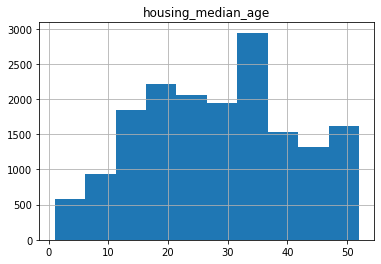

In [8]:
california_housing_dataframe.hist('housing_median_age')

In [13]:
city_names = pd.Series(['San Francisco', 'San Jose', 'Sacramento'])
population = pd.Series([852469, 1015785, 485199])

cities = pd.DataFrame({ 'City name': city_names, 'Population': population })

In [14]:
cities.reindex([2, 0, 1])

,City name,Population
2,Sacramento,485199
0,San Francisco,852469
1,San Jose,1015785


In [20]:
cities.reindex(np.random.permutation(cities.index))

,City name,Population
1,San Jose,1015785
0,San Francisco,852469
2,Sacramento,485199
